In [43]:
# Import the libraries
import pandas as pd
import numpy as np
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
import statsmodels.api as sm 
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, classification_report, roc_auc_score, f1_score, precision_score, recall_score
from plot_metric.functions import BinaryClassification
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import PowerTransformer

pd.options.display.max_rows = 200

def Find_Optimal_Cutoff(target, predicted):    
    '''Find data-driven cut-off for classification
    
    Cut-off is determined using Youden's index defined as sensitivity + specificity - 1.
    
    Parameters
    ----------
    
    target : array, shape = [n_samples]
        True binary labels.
        
    predicted : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive class,
        confidence values, or non-thresholded measure of decisions (as returned by
        “decision_function” on some classifiers).
        
    References
    ----------
    
    Ewald, B. (2006). Post hoc choice of cut points introduced bias to diagnostic research.
    Journal of clinical epidemiology, 59(8), 798-801.
    
    Steyerberg, E.W., Van Calster, B., & Pencina, M.J. (2011). Performance measures for
    prediction models and markers: evaluation of predictions and classifications.
    Revista Espanola de Cardiologia (English Edition), 64(9), 788-794.
    
    Jiménez-Valverde, A., & Lobo, J.M. (2007). Threshold criteria for conversion of probability
    of species presence to either–or presence–absence. Acta oecologica, 31(3), 361-369.
    '''
    fpr, tpr, thresholds = roc_curve(target, predicted)
    idx = np.argmax(tpr - fpr)
    return thresholds[idx]

def train_model(data_final, day):
    # List of features for training
    feature_list_for_training = [
           'sex_M',
           'age_18-29',  'age_40-49', 'age_50-59', 'age_60+',
           'substance', 
           'mood', 
           'anxiety', 
           'psychotic', 
           'cognitive', 
           'otherpsych',
           'selfharm', 
           'visit_emr_MH_non_elect', 
           'visit_emr_NonMH',
           'visit_emr_visit', 
           'visit_hosp_visit',
           'visit_hospitalized_MH', 
           'visit_hospitalized_NonMH', 
           'visit_family_gp', 
           'visit_im',
           'visit_neurology', 
           'visit_other', 
           'visit_pharmacy', 
           'visit_psychiatry',
           'EX_CHF', 
           'EX_Arrhy', 
           'EX_VD', 
           'EX_PCD', 
           'EX_PVD', 'EX_HPTN_UC',
           'EX_HPTN_C', 'EX_Para', 'Ex_OthND', 'Ex_COPD', 'Ex_Diab_UC',
           'Ex_Diab_C', 'Ex_Hptothy', 'Ex_RF', 'Ex_LD', 'Ex_PUD_NB', 'Ex_HIV',
           'Ex_Lymp', 'Ex_METS', 'Ex_Tumor', 'Ex_Rheum_A', 'Ex_Coag', 'Ex_Obesity',
           'Ex_WL', 'Ex_Fluid', 'Ex_BLA', 'Ex_DA', 'Ex_Alcohol', 'Ex_Drug',
           'Ex_Psycho', 'Ex_Dep', 'Ex_Stroke', 'Ex_Dyslipid', 'Ex_Sleep', 'Ex_IHD',
           'EX_Fall', 'EX_Urinary', 'EX_Visual', 'EX_Hearing', 'EX_Tobacco',
           'EX_Delirium', 'Ex_MS', 'EX_parkinsons'
    ]
    
    # Separate the features for training
    X = data_final[feature_list_for_training]
    # Separate the labels for training
    y = data_final['homeless']
    
    # Add the constant to the X features
    X = sm.add_constant(X)
    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

    # Fit the logistic regression model
    log_reg = sm.Logit(y_train, X_train).fit()

    # After fitting the model, we need to test the model on X_test (yhat are the predicted probabilities)
    yhat = log_reg.predict(X_test)
    # Receive the labels from yhat for the classification
    # Find optimal probability threshold by using yhat as a continuous measure
    threshold = Find_Optimal_Cutoff(y_test, yhat)

    # Find predictions to the dataframe applying the threshold
    prediction = pd.Series(yhat).map(lambda x: 1 if x > threshold else 0)
    
    # Calculate evaluation metrics
    f1 = f1_score(y_test, prediction)
    roc_auc = roc_auc_score(y_test, prediction)
    sensitivity = recall_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    number_of_records = len(data_final)
    number_ind_with_first_outcome = data_final[data_final['homeless'] == 1].count()[0]

    res = {
        'f1': round(f1, 2),
        'roc_auc': round(roc_auc, 2),
        'sensitivity': round(sensitivity, 2),
        'precision': round(precision, 2),
        'days': day,
        'number_ind_with_first_outcome': number_ind_with_first_outcome,
        'number_of_records': number_of_records
    }

#     print(day, number_of_records, number_ind_with_first_outcome)
    
    return res, X_train, X_test, y_train, y_test, prediction, log_reg, feature_list_for_training, X, y



In [ ]:
# Read the preprocessed data from an HDF file
data_final = pd.read_hdf('df_sub_homeless_preproc.h5', 'df_sub_homeless_preproc')

# Create empty DataFrames to store the results
df_results = pd.DataFrame()
df_ = pd.DataFrame()

# Define a list of time intervals
list_ = [0, 30, 60, 90, 180, 360, 720]

# Iterate over each time interval
for day in list_:
    # Filter the data based on the date difference
    data_final_ = data_final[data_final['date_difference'] >= timedelta(day)]
    
    try:
        # Train the model and get the results
        res, X_train, X_test, y_train, y_test, prediction, log_reg, feature_list_for_training, X, y = train_model(data_final_, day)
        
        # Concatenate the results to the df_results DataFrame
        df_results = pd.concat([df_results, pd.DataFrame(res.values()).T], ignore_index=True)
    except:
        # Print the day if an exception occurs during training
        print(day)

# Rename the columns of the df_results DataFrame
df_results.columns = ['f1', 'roc_auc', 'sensitivity', 'precision', 'day', 'number_ind_with_first_outcome', 'number_of_records']


In [45]:
df_results.sort_values(['roc_auc', 'sensitivity', 'precision'], ascending=False)


,f1,roc_auc,sensitivity,precision,day,number_ind_with_first_outcome,number_of_records
5,0.17,0.88,0.90,0.09,360.0,3814.0,236346.0
1,0.17,0.87,0.90,0.10,30.0,4266.0,238823.0
0,0.17,0.87,0.90,0.09,0.0,4417.0,240218.0
4,0.15,0.87,0.90,0.08,180.0,4034.0,237727.0
6,0.13,0.86,0.92,0.07,720.0,3225.0,232639.0
2,0.16,0.86,0.89,0.09,60.0,4209.0,238591.0
3,0.15,0.86,0.89,0.08,90.0,4152.0,238355.0


In [46]:
# Set the time interval for multivariate analysis
day = 360

# Filter the data based on the date difference
data_final_ = data_final[data_final['date_difference'] >= timedelta(day)]

# Train the model and get the results for the specified time interval
res, X_train, X_test, y_train, y_test, prediction, log_reg, feature_list_for_training, X, y = train_model(data_final_, day)


/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.054659
         Iterations 10


Confusion Matrix:
 [[19958  3303]
 [   39   335]]
Test accuracy = 0.858599534588534
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     23261
           1       0.09      0.90      0.17       374

    accuracy                           0.86     23635
   macro avg       0.55      0.88      0.54     23635
weighted avg       0.98      0.86      0.91     23635

F1 Score: 0.1669990029910269
AUC: 0.88%


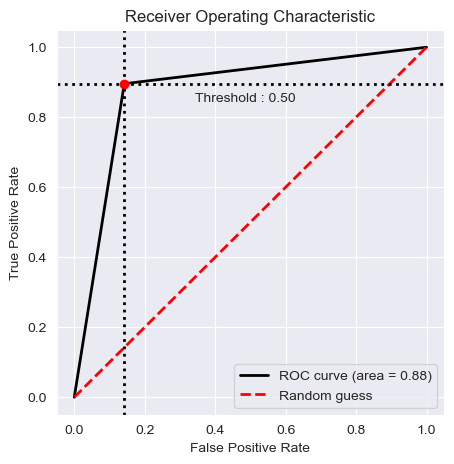

,OR,CI:2.5%,CI:97.5%,P_value
visit_emr_MH_non_elect,7.76,6.92,8.71,0.00
substance,2.70,2.37,3.07,0.00
Ex_HIV,2.37,1.65,3.40,0.00
visit_emr_NonMH,2.09,1.72,2.53,0.00
visit_hospitalized_NonMH,1.99,1.79,2.22,0.00
Ex_Drug,1.94,1.75,2.15,0.00
visit_family_gp,1.90,1.24,2.89,0.00
psychotic,1.66,1.45,1.91,0.00
mood,1.58,1.41,1.77,0.00
Ex_Fluid,1.54,1.40,1.69,0.00


In [47]:
# Calculate and print the confusion matrix for the test dataset
cm = confusion_matrix(y_test, prediction)
print("Confusion Matrix:\n", cm)

# Calculate and print the accuracy score of the model
print('Test accuracy =', accuracy_score(y_test, prediction))

# Print the classification report
print(classification_report(y_test, prediction))

# Calculate and print the F1 score
print("F1 Score:", f1_score(y_test, prediction))

# Calculate and print the AUC-ROC score
roc_auc = roc_auc_score(y_test, prediction)
print('AUC: %.2f' % roc_auc + "%")

# Visualize the ROC curve using plot_metric
bc = BinaryClassification(y_test, prediction, labels=["Class 1", "Class 2"])

# Create a figure and plot the ROC curve
plt.figure(figsize=(5, 5))
bc.plot_roc_curve()
plt.show()


# Set the time interval for multivariate analysis
day = 360

# Filter the data based on the time interval
data_final = data_final[data_final['date_difference'] > timedelta(day)]

# Retrieve the results from the logistic regression model
result = log_reg

# Calculate the confidence intervals and odds ratios
df_results = np.round(np.exp(result.conf_int()), 2)
df_results.columns = ['CI:2.5%', 'CI:97.5%']
df_results['OR'] = pd.DataFrame(np.exp(result.params))
df_results['OR'] = df_results['OR'].map(lambda x: np.round(x, 2))
df_results['P_value'] = np.round(result.pvalues.values, 2)

# Sort the results by odds ratio in descending order
df_results_sorted = df_results[['OR', 'CI:2.5%', 'CI:97.5%', 'P_value']].sort_values("OR", ascending=False)

df_results_sorted